# Coordinate System in `GoFish`

## 0. Get the Data

For this we will use the CS (3-2) emission in TW Hya, originally published in [Teague et al. (2018)](https://ui.adsabs.harvard.edu/abs/2018ApJ...864..133T). The emission is already clearly detected, but acts as a good starting point. You can download the data from [Harvard Dataverse](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/LO2QZM), making sure to place it in the directory where this notebook is.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from gofish import imagecube

In [2]:
cube = imagecube('TWHya_CS_32.fits', FOV=10.0)

## 1. Definitions

Within `GoFish` we use the inclination, $i$, and position angle, ${\rm PA}$, to define two _rotations_ which transform a disk coordinate system, $(x_{\rm disk},\, y_{\rm disk},\, z_{\rm disk})$, into the on-sky coordinates $(x_{\rm sky},\, y_{\rm sky})$. Note that because we only see things projected on the sky, the transformation from the disk-frame to the sky-frame is simple, while the return transformation is trickier if we know the disk structure is 3D. This is discussed more later on.

To begin with, the inclination of a disk is defined as the inverse cosine of the ratio of the major and minor axes of the disk, $i = \cos^{-1}(a_{\rm maj}\, / \, a_{\rm min})$. You can think of this as a rotation around the major axis of the disk. The position angle is defined as the angle from north to the _red-shifted_ major axis of the disk in an easterly (counter-clockwise) direction. You can think about this as a rotation around the line-of-sight axis in an anticlockwise direction. Note that some literature defintions for ${\rm PA}$ can vary, for example taking the closest major axis such that ${\rm PA} \in [0,\, \pi)$, so make sure to check the definitions!

There are two main functions within `GoFish` that will help with transforming between disk- and sky reference frames, ``disk_coords``, which calculates the disk-frame coordinates for each pixel for a given viewing geometry, and ``disk_to_sky``, which projects the disk-frame coordinates into on-sky positions.

### 1.1 A 2D Example

As an example, we can see how the disk structure varies for different $(i,\, {\rm PA})$ values. For a given viewing geometry, the function ``disk_coords`` will return three arrays representing the cylindrical disk-frame coordinates corresponding to each on-sky pixel. To demonstrate how this works, we can use the `plot_surface` function within `GoFish` to quickly see how the projected disk geometry looks like.

Holding $i = 45^{\circ}$ and varying ${\rm PA}$, we can see how the disk rotates.

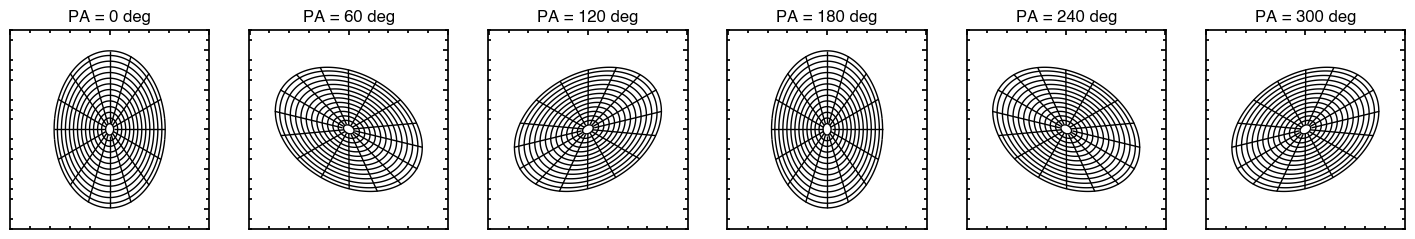

In [3]:
fig, axs = plt.subplots(ncols=6, figsize=(18, 3))

for a, ax in enumerate(axs):
    
    inc = 45.0
    PA = a * 60.0
    
    cube.plot_surface(inc=inc, PA=PA, r_max=4.0, ax=ax)
    ax.tick_params(left=0, bottom=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title('PA = {:.0f} deg'.format(PA))

The difference between say ${\rm PA} = 60^{\circ}$ and ${\rm PA} = 240^{\circ}$ can be more easily seen when we fill in the plots with the polar angle, $\theta$. Within `GoFish` this is usually called `tvals`, which runs from $-\pi$ to $\pi$, with $\theta = 0$ along the red-shfited major axis. We can add a line into the above command to fill in the plots with $\cos(\theta)$ to highlight the red- and blue-shifted sides of the disk.

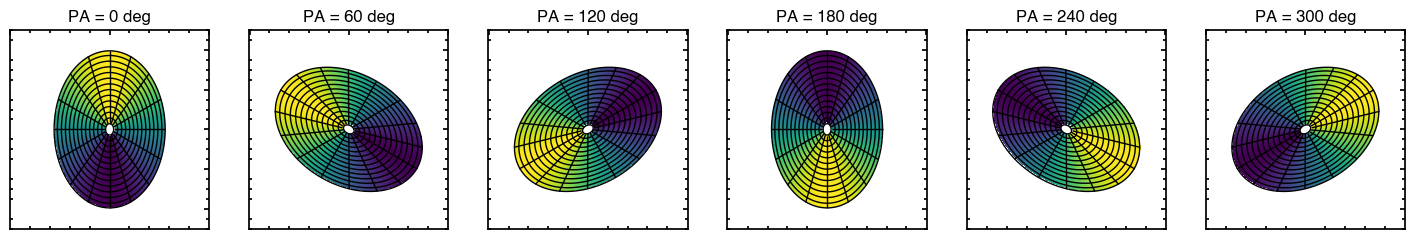

In [4]:
fig, axs = plt.subplots(ncols=6, figsize=(18, 3))

for a, ax in enumerate(axs):
    
    inc = 45.0
    PA = a * 60.0
    
    cube.plot_surface(inc=inc, PA=PA, r_max=4.0, fill='np.cos(tvals)', ax=ax)
    ax.tick_params(left=0, bottom=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title('PA = {:.0f} deg'.format(PA))

## 2. 3D Disks

With the high spatial resolution afford by ALMA, it is now possible to resolve the vertical structure of the disk as well (see [Rosenfeld et al. 2013](https://ui.adsabs.harvard.edu/abs/2013ApJ...774...16R) for a nice demonstration of this for HD 163296). Given that we have access to this information, we want to use that in our model too.

Given that we are often just concerned with a thin emission region within a 3D disk, in `GoFish` we describe a 3D structure as a 2D surface within that 3D space, defined in disk-centric cylindrical coordinates as,

$$
z(r) = z_0 \times \left( \frac{r - r_{\rm cavity}}{1^{\prime\prime}} \right)^{\psi} \times \exp \left( -\left[ \frac{r - r_{\rm cavity}}{r_{\rm taper}}\right]^{q_{\rm taper}} \right)
$$

where the second term acts as a 'correction' term in order to account for the drop in emission surface expected due to the drop in gas surface density at large radii. `r_cavity` can be used to describe an inner cavity, for example as in PDS 70. By default $r_{\rm cavity} = 0^{\prime\prime}$ and $r_{\rm taper} = \infty$, such that by including a $(z_0,\, \psi)$ pair, we can start to build concical ($\psi = 1$) or flared ($\psi > 1$) emission surfaces.

## 2.1 A Simple 3D Example

Using the above code, we can now consider a slightly flared disk with $(z_0,\, \psi) = (0.3,\, 1.2)$.

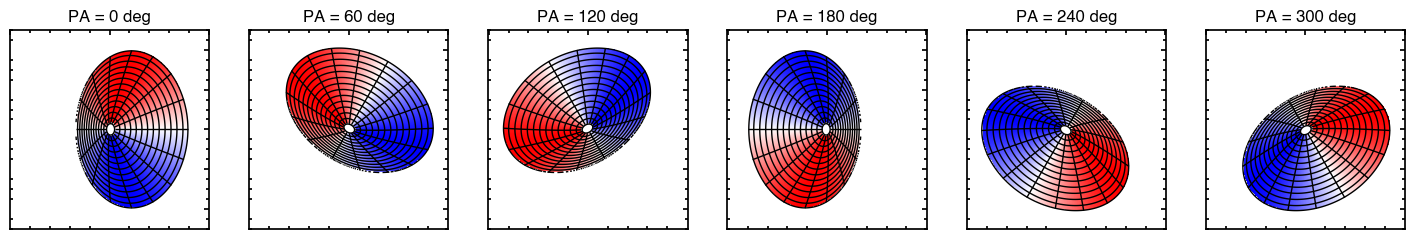

In [5]:
fig, axs = plt.subplots(ncols=6, figsize=(18, 3))

for a, ax in enumerate(axs):
    
    inc = 45.0
    PA = a * 60.0
    
    cube.plot_surface(inc=inc, PA=PA, z0=0.3, psi=1.2, r_max=4.0, ax=ax,
                      imshow_kwargs=dict(cmap='bwr'), fill='np.cos(tvals)')
    ax.tick_params(left=0, bottom=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    ax.set_title('PA = {:.0f} deg'.format(PA))

It is quite clear here that depending on the viewing geometry, one side of the disk appears shorter than the other. This is because the elevated emission surface contributed to the perceived inclination of one side of the disk, such that along the minor axis of the disk,

$$
i_{\rm perceived} \approx i_{\rm surface} \pm i_{\rm disk} = \tan^{-1}(z\, /\, r) \pm i_{\rm disk},
$$

where the side _closer_ to the observer has an _increased_ inclination, while the side _further_ from the observer has a _reduced_ inclination.

## 2.2 A Complex 3D Example

When one has very good angular resolution, it is possible to use a more complex emission surface.

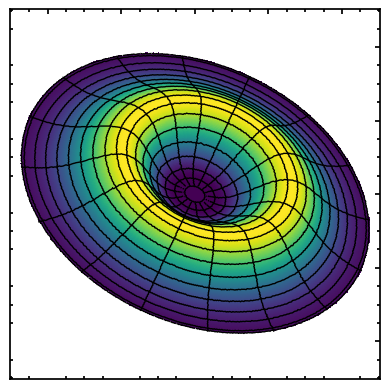

In [6]:
fig = cube.plot_surface(inc=45.0, PA=65.0,
                        z0=0.8, psi=2.5,
                        r_taper=1.7, q_taper=2.0,
                        r_cavity=0.5, r_max=5.0,
                        fill='zvals',
                        shadowed=True)

fig.axes[0].set_xticklabels([])
fig.axes[0].set_yticklabels([])
fig.axes[0].tick_params(left=0, bottom=0)

Note here that we have used the `shadowed=True` argument. This is because bits of the disk are 'shadowed' or hidden along the line of sight. Typically `GoFish` will calculate the sky-to-disk transform iteratively which works well for simple emission surfaces and is fast. When more complex emission surfaces are needed, it can employ a more robust approach which builds a 3D model which it then rotates given the viewing geometry, and then projects that onto the sky. Any function which requires some transform should accept the `shadowed` argument.

To demonstrate the difference, we can turn this off.

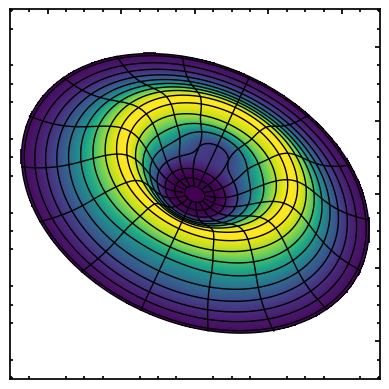

In [7]:
fig = cube.plot_surface(inc=45.0, PA=65.0,
                        z0=0.8, psi=2.5,
                        r_taper=1.7, q_taper=2.0,
                        r_cavity=0.5, r_max=5.0,
                        fill='zvals',
                        shadowed=False)
fig.axes[0].set_xticklabels([])
fig.axes[0].set_yticklabels([])
fig.axes[0].tick_params(left=0, bottom=0)

Close, but not quite right...

## 3. Disk Rotation And Total Orientation

Now that it is possible to resolve separate sides of the disk, we also need to consider the complete orientation of the disk. Consider a face-on disk. If we were to incline this disk (apply a rotation around the major axis), then we can rotate it in two directions: in one case the northern edge moves _towards_ the observer, in the other, the southern edge does. For a 2D disk, these two are identical and this is why generally literature values of disks spane $i \in [0^{\circ},\, 90^{\circ})$.

### 3.1 Negative Inclinations

However, for us it makes a difference which direction that rotation is. This can be changed by considering $i \in (-90^{\circ},\, 90^{\circ})$. This allows for the front surface to be completely specified.

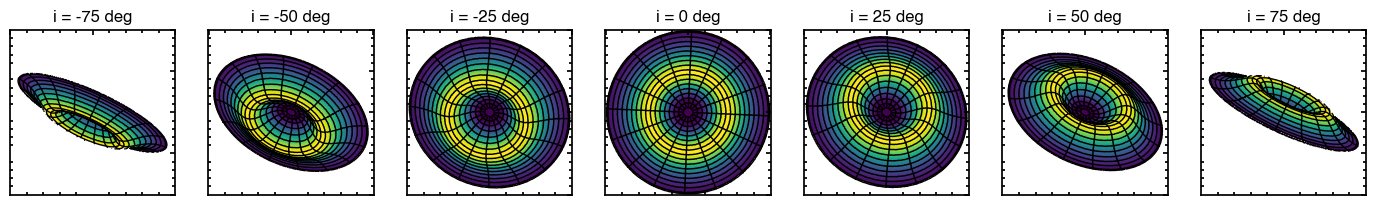

In [8]:
fig, axs = plt.subplots(ncols=7, figsize=(17.5, 2.5))

for a, ax in enumerate(axs):
    
    inc = np.linspace(-75, 75, len(axs))[a]
    
    fig = cube.plot_surface(inc=inc, PA=65.0,
                            z0=0.8, psi=2.5,
                            r_taper=1.7, q_taper=2.0,
                            r_cavity=0.5, r_max=5.0,
                            fill='zvals', ax=ax,
                            shadowed=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(left=0, bottom=0)
    ax.set_title('i = {:.0f} deg'.format(inc))


With this somewhat extreme vertical structure, this highlights the issue of rotation. Making the same plot, but filling the background with a pseudo-velocity structure projected along the line of sight:

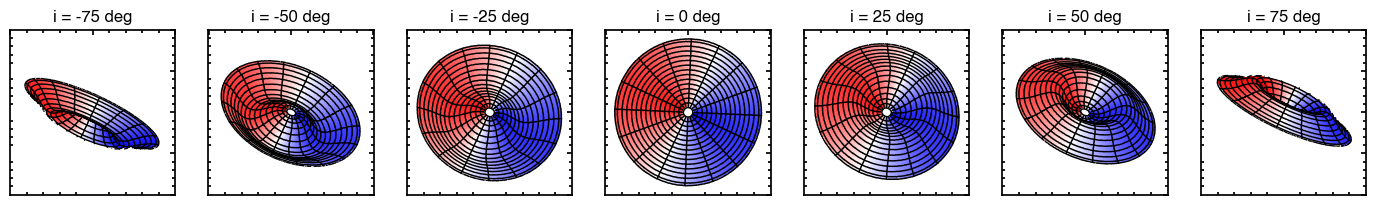

In [9]:
fig, axs = plt.subplots(ncols=7, figsize=(17.5, 2.5))

for a, ax in enumerate(axs):
    
    inc = np.linspace(-75, 75, len(axs))[a]
    
    fig = cube.plot_surface(inc=inc, PA=65.0,
                            z0=0.8, psi=2.5,
                            r_taper=1.7, q_taper=2.0,
                            r_cavity=0.5, r_max=4.5,
                            fill='rvals**-0.1 * np.cos(tvals)',
                            imshow_kwargs=dict(cmap='bwr'),
                            ax=ax, shadowed=True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(left=0, bottom=0)
    ax.set_title('i = {:.0f} deg'.format(inc))


This makes it clear that $i > 0$ represents clockwise rotation, while $i < 0$ is anti-clockwise rotation. In the extreme case of $i = \pm 90^{\circ}$, you can imagine that these are opposite sides of the disk.

### 3.2 Bottom Side of the Disk

You can also access the bottom side of the disk by flipping the sign of $z_0$,

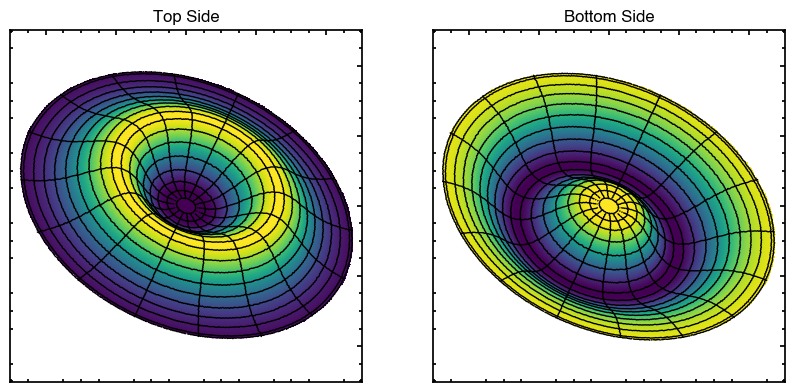

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

fig = cube.plot_surface(inc=45.0, PA=65.0,
                        z0=0.8, psi=2.5,
                        r_taper=1.7, q_taper=2.0,
                        r_cavity=0.5, r_max=5.0,
                        fill='zvals', ax=axs[0],
                        shadowed=True)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_title('Top Side')
axs[0].tick_params(left=0, bottom=0)

fig = cube.plot_surface(inc=45.0, PA=65.0,
                        z0=-0.8, psi=2.5,
                        r_taper=1.7, q_taper=2.0,
                        r_cavity=0.5, r_max=5.0,
                        fill='zvals', ax=axs[1],
                        shadowed=True)
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])
axs[1].set_title('Bottom Side')
axs[1].tick_params(left=0, bottom=0)

**NOTE** - There's currently an issue in the code that for highly inclined sources with large $z(r)$ profiles the front side of the disk may be shadowed incorrectly. A fix in underway.

## 4. User-Defined Surfaces

Sometimes it would be useful to use an emperically derived emission surface (following [Pinte et al., 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...609A..47P/abstract), for example). This can be achived by providing `GoFish` with a function, `zfunc`, which returns the emission height in arcseconds for a given midplane radius in arcseconds.

### 4.1 Example of a User-Defined Surface

First define an emission surface with some bumps and wiggles.

Text(0, 0.5, 'Height (arcsec)')

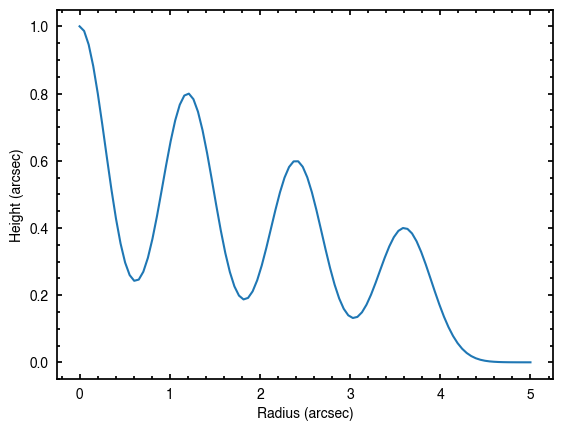

In [11]:
def z_func(r):
    z = np.zeros(r.shape)
    for i in range(4):
        z += (1.0 - i * 0.2) * np.exp(-0.5 * ((r - i * 1.2) / 0.3)**2.0)
    return np.clip(z, a_min=0.0, a_max=None)

r = np.linspace(0, 5, 100)
z = z_func(r)

fig, ax = plt.subplots()
ax.plot(r, z)
ax.set_xlabel('Radius (arcsec)')
ax.set_ylabel('Height (arcsec)')

Then provide this to `disk_coords`, `disk-to-sky` or `plot_surface`.

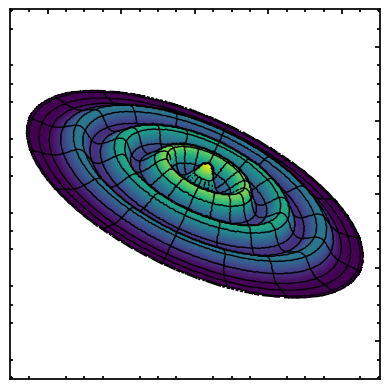

In [12]:
fig = cube.plot_surface(inc=65.0, PA=65.0, z_func=z_func,
                       r_max=5.0, fill='zvals', shadowed=True)
fig.axes[0].set_xticklabels([])
fig.axes[0].set_yticklabels([])
fig.axes[0].tick_params(left=0, bottom=0)

## 5. Disk-to-Sky Transformations

Sometimes it is useful to project things defined in the disk-frame onto the sky. For this we can use the `disk_to_sky` transformation.

### 5.1 Midplane Spiral

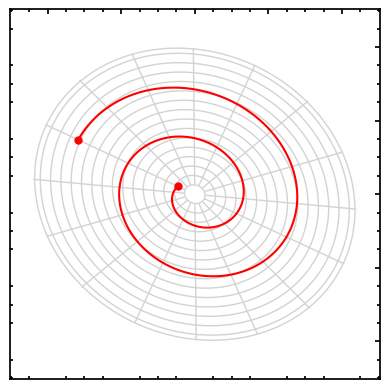

In [13]:
#define the viewing geometry

inc = 30.0
PA = 65.0

# draw a background mesh 
fig = cube.plot_surface(inc=inc, PA=PA, r_max=4.5,
                        contour_kwargs=dict(colors='lightgray', zorder=-10))
ax = fig.axes[0]

# define a midplane spiral in (arcsec, radians)

r = np.linspace(0.5, 3.5, 1000)
t = np.linspace(0, 4 * np.pi, r.size)

# calculate the transform

x_sky, y_sky = cube.disk_to_sky((r, t), inc=inc, PA=PA, coord_type='cylindrical')

# plot

ax.plot(x_sky, y_sky, color='r')
ax.scatter(x_sky[0], y_sky[0], color='r', lw=0.0)
ax.scatter(x_sky[-1], y_sky[-1], color='r', lw=0.0)

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=0, bottom=0)

### 5.2 Buoyant Spiral

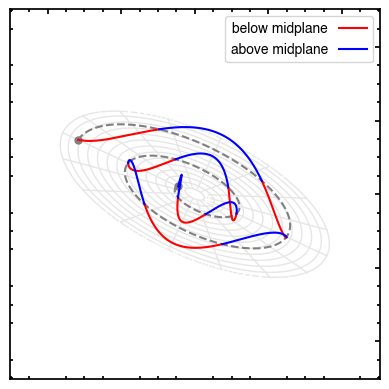

In [14]:
#define the viewing geometry

inc = 65.0
PA = 65.0

# draw a background mesh 
fig = cube.plot_surface(inc=inc, PA=PA, r_max=4.0,
                        contour_kwargs=dict(colors='0.9', zorder=-10))
ax = fig.axes[0]

# define a midplane spiral in (arcsec, radians)

r = np.linspace(0.5, 3.5, 10000)
t = np.linspace(0, 4 * np.pi, r.size)
z = 0.5 * np.sin(3.0 * t)

# calculate the transform for the midplane spiral

x_sky, y_sky = cube.disk_to_sky((r, t), inc=inc, PA=PA, coord_type='cylindrical')
l = ax.plot(x_sky, y_sky, color='gray', ls='--')
ax.scatter(x_sky[0], y_sky[0], color=l[0].get_color(), lw=0.0)
ax.scatter(x_sky[-1], y_sky[-1], color=l[0].get_color(), lw=0.0)

# overplot the buotyant spiral

x_sky, y_sky = cube.disk_to_sky((r, t, z), inc=inc, PA=PA, coord_type='cylindrical')
l = ax.plot(np.where(z < 0, x_sky, np.nan), np.where(z < 0, y_sky, np.nan),
            color='red', label='below midplane')

x_sky, y_sky = cube.disk_to_sky((r, t, z), inc=inc, PA=PA, coord_type='cylindrical')
l = ax.plot(np.where(z > 0, x_sky, np.nan), np.where(z > 0, y_sky, np.nan),
            color='blue', label='above midplane')

ax.legend(markerfirst=False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=0, bottom=0)